# Development of filter to estimate real gas consumption on pulsed meters

Energy sub-metering is used in buildings to track which sub-sytem within a building are most responsible for overall energy consumption. When sub-meter data is recorded on a fixed interval this data is useful for identifying wasteful operation, for example chiller operation during winter, or heating pumps running 24/7.

Frequently, information logged on sub-meters is recorded to the Building Management System (BMS) via **pulsed output**. This means that when a fixed amount of energy, say 1kWh, has been logged by the meter it sends a signal to the BMS that 1kWh has been consumed. The BMS typically records this information at a fixed interval, for example the number of pulses counted in a 30minute period will be logged to the BMS database.

This setup can be problematic when the amount of energy consumed at a meter is low with respect to the amount required to trigger a pulse. In the example below, a gas meter pulses only when 110kWh of gas has been consumed. Frequently gas use in the building is too low trigger a pulse during a 30 minute interval, leading to a jagged/sawtooth pattern in gas consumption that does not give a true reflection of gas use.

This notebook attempts to investigate the effectivess of a filtering/smoothing algorithm in providing a closer representation of actual gas use.

## Imports and Definitions

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
import seaborn as sns # for nice looking plots

%matplotlib inline

In [2]:
def pulse_filter(series, increment, remainder=0):
    """Filters raw input data to mimic the output that might be produced by
    a pulsed meter.
    
    The series is the raw data and the increment is the minimum value that 
    triggers a pulse"""
    
    pulses = []
    
    for n, i in enumerate(series):
        i = i + remainder
                
        remainder = i % increment
        pulse = i - remainder
                
        pulses.append(pulse)
    
    return pulses

## Load the raw data file

In this example simulated gas used as the raw data. It is then passed through a filter to approximate the output which would be achieved through a pulsed meter.

In [3]:
df = pd.read_csv('Gas.csv', index_col=0, parse_dates=True, dayfirst=True)
df.columns = ['Real'] #rename column headers

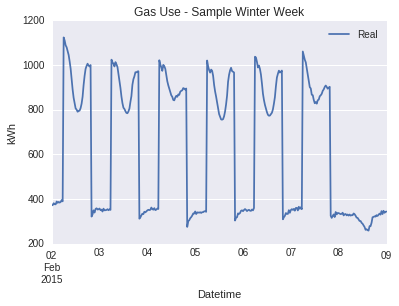

In [4]:
ax = df.truncate(before='2015-02-02', after='2015-02-09').plot()
ax.set_ylabel('kWh')
ax.set_title('Gas Use - Sample Winter Week')

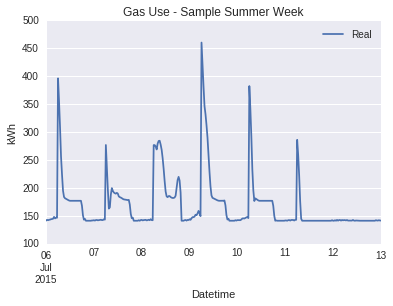

In [5]:
ax = df.truncate(before='2015-07-06', after='2015-07-13').plot()
ax.set_ylabel('kWh')
ax.set_title('Gas Use - Sample Summer Week')

## Generate Pulsed Meter Output

In [6]:
df['Meter'] = pulse_filter(df.Real, 110)
df['Meter'].to_csv('metered_gas.csv')

It can be seen below, that during winter, gas use at the side is high enough that the pulsed output provides a close representation of actual consumption. The green line, which represents the pulsed output, tracks closely the real gas consumpiton at the site.

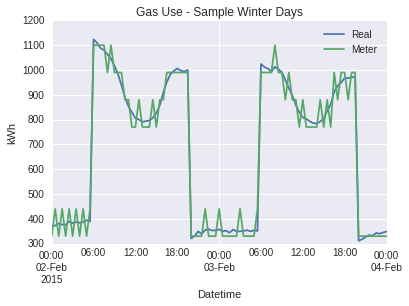

In [7]:
ax = df.truncate(before='2015-02-02', after='2015-02-04').plot()
ax.set_ylabel('kWh')
ax.set_title('Gas Use - Sample Winter Days')

Problems arise during summer however when consumption is lower, at approximately 150kWh every 30 minutes. This is higher than that represented by a single pulse (110kWh) but much lower than that represented by 2 pulses (220kWh). Thus a jagged pattern of eletricity consumption is apparent.

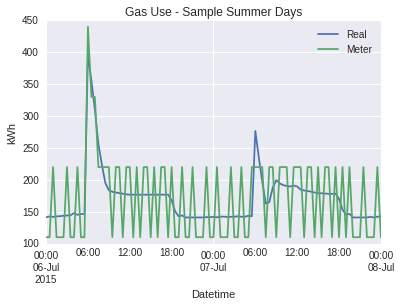

In [8]:
ax = df.truncate(before='2015-07-06', after='2015-07-08').plot()
ax.set_ylabel('kWh')
ax.set_title('Gas Use - Sample Summer Days')

It can be seen below that by totalling both the real data and the pulsed data over weekly or daily intervals the difference between them is negligible, i.e. the pulsed meter is still a useful tool in tracking building energy consumption. However it does not provide the fine grained detail required for more intricate building analytics.

### Monthly Totals

In [38]:
weekly_totals = df.resample('W').sum()
weekly_totals.index = [ts.strftime('%d-%b') for ts in weekly_totals.index]

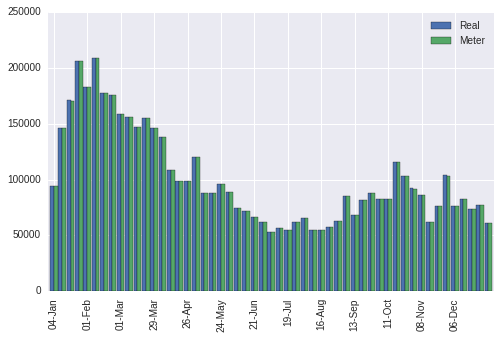

In [42]:
ax = weekly_totals.plot.bar(figsize=(8,5), width=0.9)
tiks = ax.set_xticks(range(0,52,4))
tiks = ax.set_xticklabels(weekly_totals.index[::4])

### Daily Totals

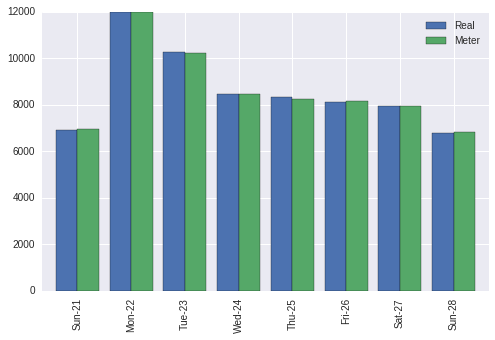

In [46]:
daily_totals = df.truncate(before='2015-06-21', after='2015-06-28 23:59').resample('D').sum()
daily_totals.index = [ts.strftime('%a-%d') for ts in daily_totals.index]
ax = daily_totals.plot.bar(figsize=(8,5), width=0.8)